In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import xarray as xarr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('Dec2018Components.csv')

In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%m/%D/%Y %H:%M:%S')

ValueError: 'D' is a bad directive in format '%m/%D/%Y %H:%M:%S'

In [5]:
df.set_index(df['DateTime'], drop=True)

In [6]:
xr = xarr.Dataset.from_dataframe(df)

# Save to netCDF
xr.to_netcdf('./NewFolder/testComponentsEvenNewer.nc')

In [6]:
ds = xarr.open_dataset('testComponentsEvenNewer.nc')

In [11]:
ds['HorizontalSpeed'] = (ds['Speed_U']**2 + ds['Speed_V']**2)**(1/2)

In [10]:
ds = ds.assign(dircalc = (['Time'], mp.wind_direction(ds.Speed_U * units.meters /units.seconds, ds.Speed_V * units.meters /units.seconds).values))

In [19]:
ds['power'] = (1/2*0.52*1.225*np.pi*132^2*ds['HorizontalSpeed']^3)/1e6

In [7]:
#Add line for block averaging trick
line = ds.isel(DateTime = -1)
line = line.assign_coords(DateTime = line.DateTime.data + np.timedelta64(10, 'M'))
ds = xarr.concat((ds,line), dim = 'DateTime')

UFuncTypeError: Cannot cast ufunc 'add' input 1 from dtype('<m8[M]') to dtype('<m8[ns]') with casting rule 'same_kind'

In [21]:
ds_30 = ds.resample(time = '30min').mean()
ds_30 = ds_30.drop_sel(DateTime = -1)

In [23]:
ds_30_restricted = ds.where(((ds_30['HorizontalSpeed']>4) | (ds_30['HorizontalSpeed']<15)))

In [25]:
fig = plt.figure()
ax = plt.subplot(1, 1,1, projection="windrose")
ax.bar(ds_30_restricted['dircalc'], ds_30_restricted['HorizontalSpeed'], normed=True, edgecolor='white')

ValueError: Unknown projection 'windrose'

<Figure size 432x288 with 0 Axes>

ValueError: x and y must be the same size

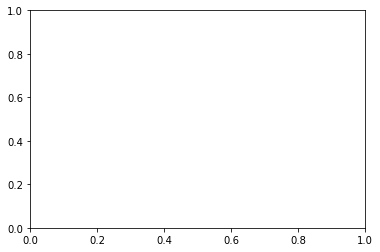

In [27]:
plt.scatter(ds_30_restricted['HorizontalSpeed'], ds['power'])